In [27]:
# boilerplate cell for stuff that comes out of the box with R, probably
# copied from https://github.com/Azure/RNNForTimeSeriesForecasting, because I am new to this stuff
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.tsa.stattools as sts
from glob import glob
from collections import UserDict
from IPython.display import Image, Markdown, display
from utils import Capturing
%matplotlib inline

# some kind soul ported a bunch of default R datasets (and more) into python, bless his soul
from pydataset import data as pdsd

pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

Original:
```R
# in order to verify that autocovariance functions actually calculate the same thing, we use the same numbers in both versions
purely_random_process = ts( c(0.68,0.85,0.72,1.00,-0.35,-0.52,1.01,-0.70,0.17,-0.60,-0.29,1.90,-0.55,-0.41,-0.58,-0.82,0.59,0.76,2.29,-0.05,0.35,1.94,0.87,0.89,-0.90,-0.37,0.79,-1.37,-1.14,-1.63,2.32,0.06,0.46,0.47,-0.70,0.84,-0.46,0.97,-1.24,-0.61,-0.03,-0.00,0.46,-1.67,0.27,-0.17,-1.02,-0.13,0.32,0.68,-1.46,0.07,-0.29,1.35,2.13,-0.86,0.93,-0.45,0.20,1.64,0.34,-0.14,0.05,0.30,-0.20,-1.02,1.08,-0.19,0.52,1.23,0.96,-1.21,-1.50,-0.47,-1.03,-0.16,-0.96,-1.94,0.25,-1.26,-0.52,-0.55,-0.83,1.06,0.43,-0.08,-0.66,1.21,-1.49,-0.17,-0.26,0.57,-1.43,0.32,-0.78,0.05,-0.19,-0.45,0.33,-0.09))
```

In [28]:
s = np.array([0.68,0.85,0.72,1.00,-0.35,-0.52,1.01,-0.70,0.17,-0.60,-0.29,1.90,-0.55,-0.41,-0.58,-0.82,0.59,0.76,2.29,-0.05,0.35,1.94,0.87,0.89,-0.90,-0.37,0.79,-1.37,-1.14,-1.63,2.32,0.06,0.46,0.47,-0.70,0.84,-0.46,0.97,-1.24,-0.61,-0.03,-0.00,0.46,-1.67,0.27,-0.17,-1.02,-0.13,0.32,0.68,-1.46,0.07,-0.29,1.35,2.13,-0.86,0.93,-0.45,0.20,1.64,0.34,-0.14,0.05,0.30,-0.20,-1.02,1.08,-0.19,0.52,1.23,0.96,-1.21,-1.50,-0.47,-1.03,-0.16,-0.96,-1.94,0.25,-1.26,-0.52,-0.55,-0.83,1.06,0.43,-0.08,-0.66,1.21,-1.49,-0.17,-0.26,0.57,-1.43,0.32,-0.78,0.05,-0.19,-0.45,0.33,-0.09])
randproc = pd.DataFrame(np.array([np.array(range(1,101)), s]).T, columns=["time","value"])
randproc

,time,value
0,1.0000,0.6800
1,2.0000,0.8500
2,3.0000,0.7200
3,4.0000,1.0000
4,5.0000,-0.3500
5,6.0000,-0.5200
6,7.0000,1.0100
7,8.0000,-0.7000
8,9.0000,0.1700
9,10.0000,-0.6000


Original R command and output:
```R
> (acf(purely_random_process,type='covariance'))
Autocovariances of series 'randproc', by lag

       0        1        2        3        4        5        6        7 
 0.83902 -0.00531  0.08063  0.01922  0.00519  0.16245 -0.13658  0.05638 
       8        9       10       11       12       13       14       15 
-0.12743  0.01815  0.03021 -0.09512  0.12323 -0.16105  0.10752  0.10419 
      16       17       18       19       20 
-0.02777  0.03950 -0.09769  0.11042 -0.12643 
```

In [29]:
# newer versions of statsmodels will have nlag param
acovvals = sts.acovf(randproc['value'])
acovvals

array([ 8.3902e-01, -5.3133e-03,  8.0632e-02,  1.9215e-02,  5.1875e-03,
        1.6245e-01, -1.3658e-01,  5.6378e-02, -1.2743e-01,  1.8152e-02,
        3.0212e-02, -9.5120e-02,  1.2323e-01, -1.6105e-01,  1.0752e-01,
        1.0419e-01, -2.7766e-02,  3.9504e-02, -9.7692e-02,  1.1042e-01,
       -1.2643e-01,  3.8092e-02, -1.5766e-02, -9.5397e-02,  7.3289e-02,
       -1.5514e-01, -5.3739e-02, -3.5716e-02, -4.8073e-02,  4.4629e-02,
       -9.2198e-03,  1.1295e-01, -7.8404e-02,  1.0703e-01,  1.9856e-02,
       -4.2191e-02,  1.4186e-01,  3.9385e-03,  1.0235e-01, -3.9478e-02,
       -4.9356e-02, -6.3861e-02,  1.0943e-03,  7.7893e-02, -1.1114e-01,
        4.1183e-02, -1.1973e-02, -1.1584e-02,  1.3899e-01, -2.7532e-02,
        4.0232e-02,  3.6073e-03,  6.9347e-02,  3.0235e-02, -5.4159e-02,
       -8.9056e-02, -8.3687e-02,  2.0587e-02, -2.0070e-02, -5.6304e-02,
       -3.3997e-02, -1.0269e-02, -3.7334e-02,  1.8371e-02, -2.5715e-03,
        3.9323e-02, -1.9345e-03,  5.5757e-02, -3.8128e-03,  8.00

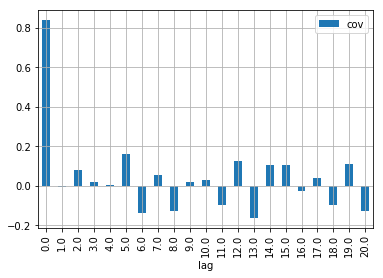

In [30]:
# just trying to visualise it
acov = pd.DataFrame(np.array([np.array(range(len(acovvals))), acovvals]).T, columns=["lag","cov"])
acov[acov["lag"]<=20].plot(x="lag",y="cov",kind="bar",grid=True)

Original:
```R
> (acf(purely_random_process,main='Correlogram of a purely random process'))
Autocorrelations of series 'randproc', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.006  0.096  0.023  0.006  0.194 -0.163  0.067 -0.152  0.022  0.036 
    11     12     13     14     15     16     17     18     19     20 
-0.113  0.147 -0.192  0.128  0.124 -0.033  0.047 -0.116  0.132 -0.151 
```

In [32]:
acorvals = sts.acf(randproc['value'])
acorvals

array([ 1.    , -0.0063,  0.0961,  0.0229,  0.0062,  0.1936, -0.1628,
        0.0672, -0.1519,  0.0216,  0.036 , -0.1134,  0.1469, -0.1919,
        0.1281,  0.1242, -0.0331,  0.0471, -0.1164,  0.1316, -0.1507,
        0.0454, -0.0188, -0.1137,  0.0874, -0.1849, -0.064 , -0.0426,
       -0.0573,  0.0532, -0.011 ,  0.1346, -0.0934,  0.1276,  0.0237,
       -0.0503,  0.1691,  0.0047,  0.122 , -0.0471, -0.0588])

Original:
```R
acf(purely_random_process,main='Correlogram of a purely random process')
```

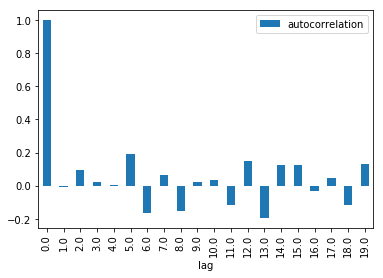

In [34]:
acor = pd.DataFrame(np.array([np.array(range(len(acorvals))),acorvals]).T,columns=['lag','autocorrelation'])
acor[:20].plot(x="lag",y="autocorrelation", kind="bar")